In [1]:
## conda requirements
# !conda install --file ../env/byoml_sklearn.environment.yml
# !conda activate byoml_sklearn 
# !pip install -r ../env/byoml_sklearn.requirements.txt
## pip-only requirements:
# !pip install waylay-beta scikit-learn==0.22 seaborn tenacity

In [2]:
from datetime import datetime
from random import random
run_id = f"{datetime.now():%Y-%m-%d}-{1000 * random():04.0f}"
MODEL_NAME=f'tutorial-{run_id}'
MODEL_NAME

'tutorial-2021-06-10-0608'

In this notebook we will show how you can integrate a scikit-learn model with our platform. We will make use of our Python SDK, which you can install by executing: 

`pip install waylay-beta`

This demo depends on some additional libraries:

`pip install scikit-learn==0.22 seaborn tenacity`

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt

## Generated dataset

First let's create a dataset generator for a temperature and light sensor consisting of 
* three gaussian blobs with fixed sized around fixed centers 
* a uniform scattering of data, the candidate outliers. 

In [4]:
col_tmp = 'Temperature'
col_amb = 'Light Ambience'
col_src = 'Source'
col_features = [col_tmp, col_amb]

def generate_dataset(samples=300, outliers=0.1):
    blob_data =  make_blobs(
        centers=[[16, 0], [21, 1200], [19, 600]], 
        cluster_std=[[1, 0], [0.5, 150], [0.7, 180]], 
        n_features=2, 
        n_samples=samples
    )
    dataset_blob = pd.DataFrame(blob_data[0], columns=[col_tmp, col_amb])
    dataset_blob[col_src] = 'blob'

    outlier_count = int(outliers * samples)
    outlier_data = np.random.uniform(low=[13, 0], high=[24, 2000], size=(outlier_count,2))
    dataset_outliers = pd.DataFrame(outlier_data, columns=[col_tmp, col_amb])
    dataset_outliers[col_src] = 'uniform'
    
    return dataset_blob.append(dataset_outliers, ignore_index=True).sample(n=samples)



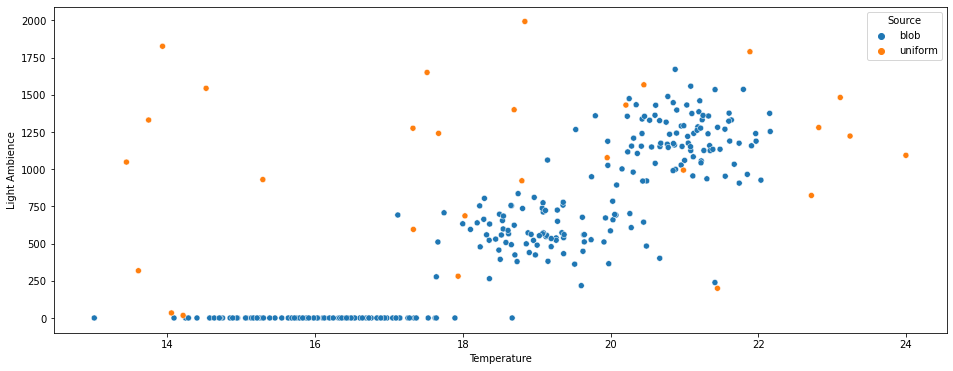

In [5]:
dataset_train = generate_dataset(outliers=0.1)
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x=col_tmp, y=col_amb, hue=col_src, data=dataset_train)


## Create a model

In this example we will use an IsolationForest to detect outliers, for which later on alarms can be generated.

In [6]:
from sklearn.ensemble import IsolationForest

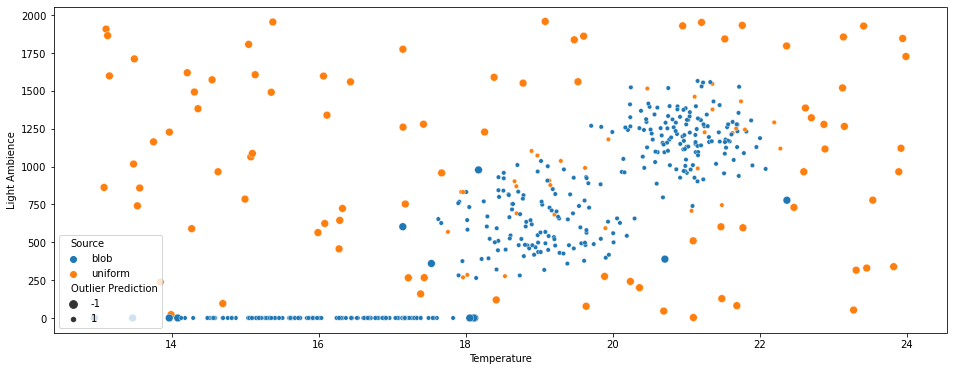

In [7]:
# we use the knowledge that 0.1 of the datapoints are expected to be outliers
model = IsolationForest(contamination=0.1)
model.fit(dataset_train[col_features])

# you could try other sample counts and outlier proportions here ...
dataset_validate = generate_dataset(samples=500, outliers=0.3)
col_predict = 'Outlier Prediction'
dataset_predict = dataset_validate.copy()
dataset_predict[col_predict] = model.predict(dataset_validate[col_features])

plt.figure(figsize=(16, 6))
ax = sns.scatterplot(
    x=col_tmp, y=col_amb,
    hue=col_src, 
    size=col_predict, sizes=[60,20], 
    data=dataset_predict
)

Let's have a look of the performance of this model. 

The sklearn `confusion_matrix` will count expected predictions (whether the datapoint came from the _uniform_ or _blob_ distributions), with the actual classification by the model.

Of course we expect quite some _false negative_ classifications, where samples from the _uniform_ distribution happen to be consistent with the _blobs_.

In [8]:
def report(dataset_predict):
    expected = dataset_predict[col_src].map(lambda x: 1 if x=='blob' else -1)
    predicted = dataset_predict[col_predict]
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
    display(pd.DataFrame(
        confusion_matrix(expected, predicted),
        columns=['Detected', 'Not Detected'],
        index=['Uniform', 'Blob']
    ))
    display(pd.DataFrame(
        [
            precision_score(expected,predicted),
            recall_score(expected,predicted),
            f1_score(expected,predicted)
        ],
        columns=['Score'],
        index=['Precision', 'Recall', 'F1']
    ))

report(dataset_predict)

,Detected,Not Detected
Uniform,85,32
Blob,12,371


,Score
Precision,0.920596
Recall,0.968668
F1,0.944020


## Upload and test the model

When the model is ready, we can upload it to the platform. First we need to save it, afterwards we can use the SDK to upload and call it. 
When uploading the model we need to provide some basic information. Like:
- which framework: `sklearn`, `tensorflow`, `pytorch` or `xgboost`
- a name for the model
- the model file (or directory for TensorFlow models)
- an optional description

In [9]:
from waylay import WaylayClient, RestResponseError
waylay = WaylayClient.from_profile()

In [10]:
try:
    waylay.byoml.model.remove(MODEL_NAME)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'Model does not exist'; DELETE 'https://byom-staging.waylay.io/models/tutorial-2021-06-10-0608')"

In [11]:
waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='sklearn', 
    description='isolationforest example'
)

{'message': 'Model successfully uploaded'}

To validate that the local and uploaded model behave the same, we extract a small sample from training data set.

In [12]:
sample = dataset_train[dataset_train[col_src]=='blob'].iloc[0:3]
sample = sample.append(dataset_train[dataset_train[col_src]=='uniform'].iloc[0:3]) 
sample

,Temperature,Light Ambience,Source
207,21.852006,965.416909,blob
104,21.675057,1033.463711,blob
283,19.088591,712.352510,blob
315,22.819816,1280.210133,uniform
324,19.954626,1077.548388,uniform
310,15.292208,930.459405,uniform


Using sample data to test the local model

In [13]:
sample['Local Prediction'] = model.predict(sample[col_features])
sample

,Temperature,Light Ambience,Source,Local Prediction
207,21.852006,965.416909,blob,1
104,21.675057,1033.463711,blob,1
283,19.088591,712.352510,blob,1
315,22.819816,1280.210133,uniform,-1
324,19.954626,1077.548388,uniform,1
310,15.292208,930.459405,uniform,-1


The same using the model served by BYOML.

Note that it takes a few seconds to activate a new model. SDK actions such as `byoml.model.predict` will retry a few times until the model is ready.

In [14]:
sample['Byoml Prediction'] = waylay.byoml.model.predict(MODEL_NAME, sample[col_features])

sample

,Temperature,Light Ambience,Source,Local Prediction,Byoml Prediction
207,21.852006,965.416909,blob,1,1
104,21.675057,1033.463711,blob,1,1
283,19.088591,712.352510,blob,1,1
315,22.819816,1280.210133,uniform,-1,-1
324,19.954626,1077.548388,uniform,1,1
310,15.292208,930.459405,uniform,-1,-1


Let's use the remote model to run on a newly generated dataset, and indicate the outliers predicted by the model.

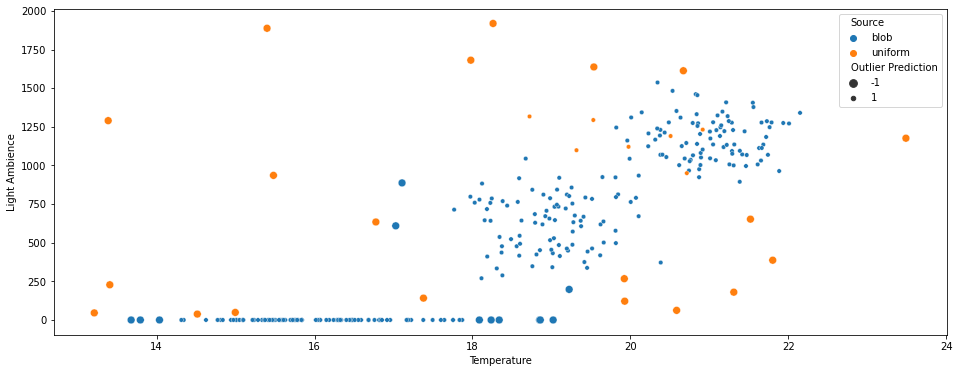

In [15]:
dataset_byoml = generate_dataset()

byoml_prediction = waylay.byoml.model.predict(MODEL_NAME, dataset_byoml[col_features])

dataset_byoml[col_predict] = byoml_prediction

plt.figure(figsize=(16, 6))
ax = sns.scatterplot(
    x=col_tmp, y=col_amb, hue=col_src, size=col_predict, sizes=[60,20], data=dataset_byoml
)

## Upload and test with a Data Query

In the example above we created a toy dataset, but in real world use cases, you probably want to use data already available in Waylay. 

Let's simulate that by first uploading 10 weeks of data and then use a dedicated Query to fetch the data.

Uploading the dataset above can also be done using the SDK, we will convert it to a timestamped dataset first:

In [16]:
data_until = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
upload_count= 10 * 7 * 24 

dataset_import = generate_dataset(upload_count)
data_until
index = pd.date_range(end=data_until, periods=upload_count, freq='1H')

dataset_import = dataset_import.set_index(index)
dataset_import

,Temperature,Light Ambience,Source
2021-04-01 01:00:00,20.304239,611.879247,uniform
2021-04-01 02:00:00,17.077256,0.000000,blob
2021-04-01 03:00:00,20.874421,1133.467107,blob
2021-04-01 04:00:00,16.553251,0.000000,blob
2021-04-01 05:00:00,21.316076,1641.792861,uniform
...,...,...,...
2021-06-09 20:00:00,18.003273,531.624788,blob
2021-06-09 21:00:00,15.423242,0.000000,blob
2021-06-09 22:00:00,20.748920,1391.815315,blob
2021-06-09 23:00:00,17.759768,908.947795,blob


Timeseries data in waylay is normally associated with a _resource_. It is the entity that contains descriptions of the device (or other source) of IoT events. 

The `waylay.api.resource` actions let you manage these _resources.


In [17]:
resource_id = f'byoml-{MODEL_NAME}'
waylay.api.resource.update(resource_id, body={
    'id': resource_id,
    'name': resource_id
})

{'id': 'byoml-tutorial-2021-06-10-0608',
 'name': 'byoml-tutorial-2021-06-10-0608'}

Now let's import this data into Waylay using the `waylay.timeseries.etl_tool` for bulk timeseries uploads.

In [18]:
etl_import = waylay.timeseries.etl_tool.prepare_import(
    dataset_import,
    name= f'byoml-{MODEL_NAME}',
    resource=resource_id,
    timestamp_timezone='UTC'
)
etl_import = waylay.timeseries.etl_tool.initiate_import(etl_import)

100%|██████████| 3.00/3.00 [00:00<00:00, 59.0series/s]


Uploading content to etl-import/upload/byoml-tutorial-2021-06-10-0608-timeseries.csv.gz ...
... done.


Importing data this way is an asynchronous process. 

Use `waylay.timeseries.etl_tool.check_import` to check on
the progress before continuing.

In [19]:
from IPython.display import HTML
from tenacity import Retrying, stop_after_attempt, wait_fixed

for attempt in Retrying(stop=stop_after_attempt(10),wait=wait_fixed(10)):
    with attempt:

        import_job = waylay.timeseries.etl_tool.check_import(etl_import)

        display(HTML(import_job.to_html()))

        if import_job.status != 'done':
            raise TryAgain

In [20]:
from IPython.display import HTML

import_job = waylay.timeseries.etl_tool.check_import(etl_import)
display(HTML(import_job.to_html()))

Once an ETL upload has been completed, you can remove the import files with `timeseries.etl_tool.cleanup_import`.

In [21]:
import_job = waylay.timeseries.etl_tool.cleanup_import(etl_import)
display(HTML(import_job.to_html()))

After uploading the dataset, we can use it in a Query. 

Let's query the last 7 days directly: 

In [22]:
query_name=f"query-{resource_id}"
query = {
    "window": "P7D",
    "data" : [
        {'resource': resource_id, 'metric': column}
        for column in col_features
    ]
}
waylay.analytics.query.execute(body=query)

resource                  byoml-tutorial-2021-06-10-0608               
metric                                       Temperature Light Ambience
timestamp                                                              
2021-06-03 10:00:00+00:00                      14.084936       0.000000
2021-06-03 11:00:00+00:00                      17.029947       0.000000
2021-06-03 12:00:00+00:00                      17.906421     522.217791
2021-06-03 13:00:00+00:00                      17.594101    1007.471374
2021-06-03 14:00:00+00:00                      19.336249     398.833396
...                                                  ...            ...
2021-06-09 20:00:00+00:00                      18.003273     531.624788
2021-06-09 21:00:00+00:00                      15.423242       0.000000
2021-06-09 22:00:00+00:00                      20.748920    1391.815315
2021-06-09 23:00:00+00:00                      17.759768     908.947795
2021-06-10 00:00:00+00:00                      16.388829       0.000000

[159 rows x 2 columns]

We'll save this query under a name, so that we can reuse it. 

In [23]:
query_name=f"query-{resource_id}"
waylay.analytics.query.replace(query_name, body={
    'query': query
})
waylay.analytics.query.get(query_name)

{'data': [{'metric': 'Temperature',
   'resource': 'byoml-tutorial-2021-06-10-0608'},
  {'metric': 'Light Ambience', 'resource': 'byoml-tutorial-2021-06-10-0608'}],
 'window': 'P7D'}

You can still override the properties of the query when executing them with `waylay.analytics.query.data`.

<AxesSubplot:xlabel='timestamp'>

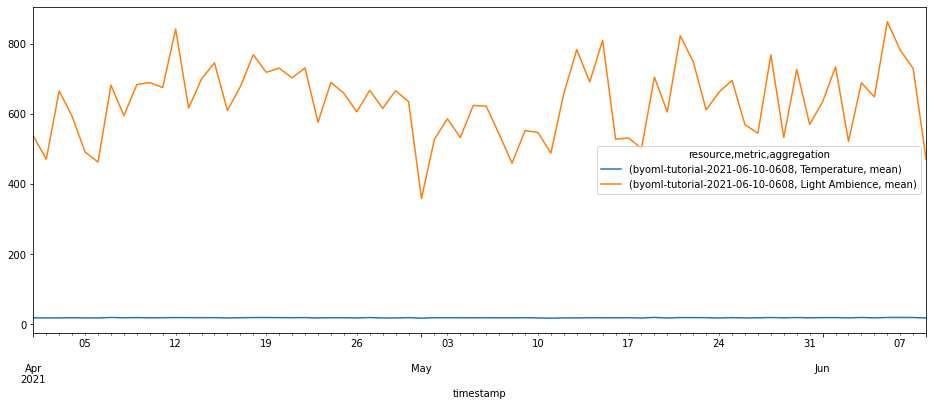

In [24]:
waylay.analytics.query.data(
    query_name, params={ 'window': 'P70D', 'aggregation': 'mean', 'freq': 'P1D' }
).plot(figsize=(16, 6))

Let's use this to select a new training set and validation set for our model

In [25]:
data_previous_month = waylay.analytics.query.data(query_name, params={'window': 'P30D', 'until': '-P30D'})
data_previous_month

resource                  byoml-tutorial-2021-06-10-0608               
metric                                       Temperature Light Ambience
timestamp                                                              
2021-04-11 10:00:00+00:00                      22.681975      85.368456
2021-04-11 11:00:00+00:00                      19.900808     469.563440
2021-04-11 12:00:00+00:00                      18.649878     840.173711
2021-04-11 13:00:00+00:00                      15.408460       0.000000
2021-04-11 14:00:00+00:00                      14.977969       0.000000
...                                                  ...            ...
2021-05-11 05:00:00+00:00                      15.504726       0.000000
2021-05-11 06:00:00+00:00                      20.034452     509.310726
2021-05-11 07:00:00+00:00                      19.860960    1167.894679
2021-05-11 08:00:00+00:00                      19.818953    1359.546598
2021-05-11 09:00:00+00:00                      19.947515    1716.998098

[720 rows x 2 columns]

In [26]:
data_last_week = waylay.analytics.query.data(query_name, params={ 'until': '-P1D' })
data_last_week

resource                  byoml-tutorial-2021-06-10-0608               
metric                                       Temperature Light Ambience
timestamp                                                              
2021-06-02 10:00:00+00:00                      20.828491    1144.912028
2021-06-02 11:00:00+00:00                      18.003529     577.306661
2021-06-02 12:00:00+00:00                      19.771934     586.341410
2021-06-02 13:00:00+00:00                      20.274951    1400.171871
2021-06-02 14:00:00+00:00                      15.138903       0.000000
...                                                  ...            ...
2021-06-09 05:00:00+00:00                      15.888744       0.000000
2021-06-09 06:00:00+00:00                      18.718308     458.803332
2021-06-09 07:00:00+00:00                      20.656024     995.553641
2021-06-09 08:00:00+00:00                      19.768024     827.529160
2021-06-09 09:00:00+00:00                      20.357411     987.925417

[168 rows x 2 columns]

We can now do the same as we did above, but now using data directly from Waylay, which will also help when we make a rule with this model and Query.

In [27]:
model = IsolationForest()
model.fit(data_previous_month)

waylay.byoml.model.replace(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='sklearn', 
    description='isolationforest example'
)

{'message': 'Model successfully uploaded'}

We can now grab other data to do the validation:

In [28]:
for attempt in Retrying(stop=stop_after_attempt(10),wait=wait_fixed(5)):
    with attempt:

        data_last_week_predict = waylay.byoml.model.predict(MODEL_NAME, data_last_week)

data_last_week_predict

array([ 1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [29]:
data_last_week[col_predict] = waylay.byoml.model.predict(MODEL_NAME, data_last_week)
data_last_week

resource                  byoml-tutorial-2021-06-10-0608                 \
metric                                       Temperature Light Ambience   
timestamp                                                                 
2021-06-02 10:00:00+00:00                      20.828491    1144.912028   
2021-06-02 11:00:00+00:00                      18.003529     577.306661   
2021-06-02 12:00:00+00:00                      19.771934     586.341410   
2021-06-02 13:00:00+00:00                      20.274951    1400.171871   
2021-06-02 14:00:00+00:00                      15.138903       0.000000   
...                                                  ...            ...   
2021-06-09 05:00:00+00:00                      15.888744       0.000000   
2021-06-09 06:00:00+00:00                      18.718308     458.803332   
2021-06-09 07:00:00+00:00                      20.656024     995.553641   
2021-06-09 08:00:00+00:00                      19.768024     827.529160   
2021-06-09 09:00:00+00:00                      20.357411     987.925417   

resource                  Outlier Prediction  
metric                                        
timestamp                                     
2021-06-02 10:00:00+00:00                  1  
2021-06-02 11:00:00+00:00                  1  
2021-06-02 12:00:00+00:00                  1  
2021-06-02 13:00:00+00:00                  1  
2021-06-02 14:00:00+00:00                  1  
...                                      ...  
2021-06-09 05:00:00+00:00                  1  
2021-06-09 06:00:00+00:00                  1  
2021-06-09 07:00:00+00:00                  1  
2021-06-09 08:00:00+00:00                  1  
2021-06-09 09:00:00+00:00                  1  

[168 rows x 3 columns]

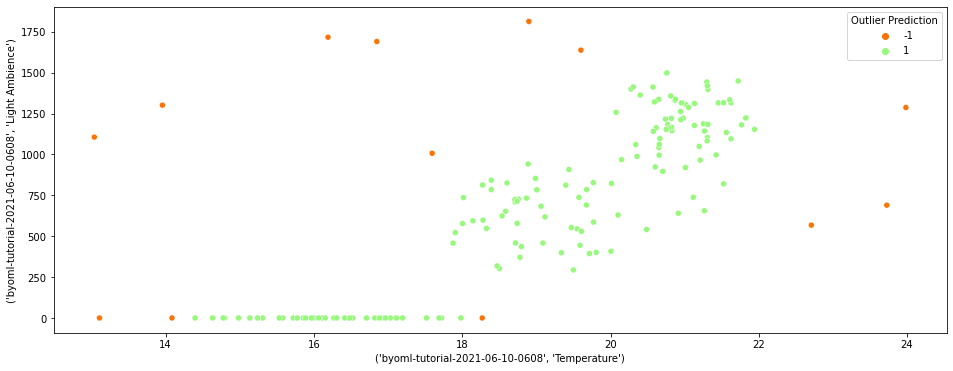

In [30]:
plt.figure(figsize=(16, 6))
cols = data_last_week.columns
ax = sns.scatterplot(
    x=(resource_id, col_tmp),
    y=(resource_id, col_amb),
    hue=col_predict, 
    palette=['xkcd:orange','xkcd:light green'], 
    data=data_last_week
)

#### Cleanup
We delete the entities that were created on the Waylay Platform
* the byoml model
* the query definition
* the waylay resource and its associated data


In [31]:
pd.DataFrame(
    index=['model','resource','query'], 
    data=[MODEL_NAME,resource_id,query_name], 
    columns=['id']
)

,id
model,tutorial-2021-06-10-0608
resource,byoml-tutorial-2021-06-10-0608
query,query-byoml-tutorial-2021-06-10-0608


In [32]:
waylay.analytics.query.remove(query_name)
waylay.api.resource.remove(resource_id)
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model successfully deleted'}